## **Spark** **Project**

In this project, we use spark to analyze the dataset reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system.

In [1]:
!ls

sample_data


In [2]:
# Download spark from the website and install it
! apt-get update
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
! wget -q https://dlcdn.apache.org/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz
! tar xf spark-3.4.1-bin-hadoop3.tgz
! pip install -q findspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [458 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [860 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,241 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [980 kB]
Get:13 http://a

In [3]:
# set up the environment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [4]:
!ls

sample_data  spark-3.4.1-bin-hadoop3  spark-3.4.1-bin-hadoop3.tgz


In [5]:
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [6]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
spark

####**Dowload** **and** **preprocessing** **Chicago's** **Report** **Crime** **Data**

In [7]:
# Download the data
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD

--2023-08-20 17:25:31--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv?accessType=DOWNLOAD’

rows.csv?accessType     [  <=>               ]   1.73G  3.17MB/s    in 15m 34s 

2023-08-20 17:41:06 (1.90 MB/s) - ‘rows.csv?accessType=DOWNLOAD’ saved [1856229146]



In [8]:
!ls

'rows.csv?accessType=DOWNLOAD'	 spark-3.4.1-bin-hadoop3
 sample_data			 spark-3.4.1-bin-hadoop3.tgz


In [9]:
# Rename the file as crimes_report
! mv rows.csv?accessType=DOWNLOAD crimes_report.csv

In [10]:
# Read the first 5 rows of the file
from pyspark.sql.functions import to_timestamp,col,lit
#rc = spark.read.csv('crimes_report.csv', header=True).withColumn('Date', to_timestamp(col('Date'),'yyyy-MM-dd HH:mm:ss')).filter(col('Date') < lit('2018-11-12'))
rc = spark.read.csv('crimes_report.csv', header=True).withColumn('Date', to_timestamp(col('Date'),'MM/dd/yyyy HH:mm:ss a')).filter(col('Date') < lit('2018-11-12'))
rc.show(5)

+--------+-----------+-------------------+-------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|              Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+-------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
| 1896258|    G749215|2001-12-15 02:00:00|   011XX N STATE ST|0460|           BATTERY|              SIMPLE|              STREET| false|   false|1824|     018|null|          null|     08B|        n

####**Schemas**

In [11]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [12]:
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, DoubleType, IntegerType, DateType

In [13]:
rc.columns

['ID',
 'Case Number',
 'Date',
 'Block',
 'IUCR',
 'Primary Type',
 'Description',
 'Location Description',
 'Arrest',
 'Domestic',
 'Beat',
 'District',
 'Ward',
 'Community Area',
 'FBI Code',
 'X Coordinate',
 'Y Coordinate',
 'Year',
 'Updated On',
 'Latitude',
 'Longitude',
 'Location']

In [14]:
from traitlets.traitlets import Integer
labels =[
    ('ID', StringType()),
    ('Case Number',StringType()),
    ('Date', TimestampType()),
    ('Block', StringType()),
    ('IUCR', StringType()),
    ('Primary Type',StringType()),
    ('Description', StringType()),
    ('Location Description', StringType()),
    ('Arrest',StringType()),
    ('Domestic',BooleanType()),
    ('Beat',StringType()),
    ('District',StringType()),
    ('Ward',StringType()),
    ('Community Area',StringType()),
    ('FBI Code',StringType()),
    ('X Coordinate',StringType()),
    ('Y Coordinate',StringType()),
    ('Year',IntegerType()),
    ('Updated On',StringType()),
    ('Latitude',DoubleType()),
    ('Longitude',DoubleType()),
    ('Location',StringType())
]

In [15]:
schema = StructType([StructField (x[0],x[1],True) for x in labels])
schema

StructType([StructField('ID', StringType(), True), StructField('Case Number', StringType(), True), StructField('Date', TimestampType(), True), StructField('Block', StringType(), True), StructField('IUCR', StringType(), True), StructField('Primary Type', StringType(), True), StructField('Description', StringType(), True), StructField('Location Description', StringType(), True), StructField('Arrest', StringType(), True), StructField('Domestic', BooleanType(), True), StructField('Beat', StringType(), True), StructField('District', StringType(), True), StructField('Ward', StringType(), True), StructField('Community Area', StringType(), True), StructField('FBI Code', StringType(), True), StructField('X Coordinate', StringType(), True), StructField('Y Coordinate', StringType(), True), StructField('Year', IntegerType(), True), StructField('Updated On', StringType(), True), StructField('Latitude', DoubleType(), True), StructField('Longitude', DoubleType(), True), StructField('Location', String

In [16]:
rc = spark.read.csv('crimes_report.csv', schema=schema)
rc.printSchema()
#c = spark.read.csv('crimes_report.csv')
#rc.head()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: boolean (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [17]:
rc.show(5)

+--------+-----------+----+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+----+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|null|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|    null|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|null|          Updated On|    null|    

We find some null values. This is because some format cannot read by schema.

####**Woring with columns**

In [18]:
# Read the file again
from pyspark.sql.functions import to_timestamp,col,lit
#rc = spark.read.csv('crimes_report.csv', header=True).withColumn('Date', to_timestamp(col('Date'),'yyyy-MM-dd HH:mm:ss')).filter(col('Date') < lit('2018-11-12'))
rc = spark.read.csv('crimes_report.csv', header=True).withColumn('Date', to_timestamp(col('Date'),'MM/dd/yyyy HH:mm:ss a')).filter(col('Date') < lit('2018-11-12'))
rc.show(5)

+--------+-----------+-------------------+-------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|              Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+-------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
| 1896258|    G749215|2001-12-15 02:00:00|   011XX N STATE ST|0460|           BATTERY|              SIMPLE|              STREET| false|   false|1824|     018|null|          null|     08B|        n

In [19]:
rc.select(rc.IUCR).show(5)
rc.select(col('IUCR')).show(5)

+----+
|IUCR|
+----+
|0460|
|1153|
|1153|
|1153|
|0820|
+----+
only showing top 5 rows

+----+
|IUCR|
+----+
|0460|
|1153|
|1153|
|1153|
|0820|
+----+
only showing top 5 rows



In [20]:
rc.select('Case Number', 'Date', 'Arrest').show(5)

+-----------+-------------------+------+
|Case Number|               Date|Arrest|
+-----------+-------------------+------+
|    G749215|2001-12-15 02:00:00| false|
|   JC212744|2015-02-02 10:00:00| false|
|   JA366925|2001-01-01 11:00:00| false|
|   JC212959|2018-01-01 08:00:00| false|
|   JB166009|2017-10-13 09:00:00| false|
+-----------+-------------------+------+
only showing top 5 rows



In [21]:
from pyspark.sql.functions import lit

In [22]:
# Add a column
rc.withColumn('One', lit(1)).show(5)

+--------+-----------+-------------------+-------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+---+
|      ID|Case Number|               Date|              Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|One|
+--------+-----------+-------------------+-------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+---+
| 1896258|    G749215|2001-12-15 02:00:00|   011XX N STATE ST|0460|           BATTERY|              SIMPLE|              STREET| false|   false|1824|     018|null|          null|     0

In [23]:
# Drop the column IUCR
rc = rc.drop('IUCR')
rc.show()

+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 1896258|    G749215|2001-12-15 02:00:00|    011XX N STATE ST|             BATTERY|              SIMPLE|              STREET| false|   false|

####**Working with rows**

In [24]:
# Add an additional day, 15-Nov-2018, to our dataset
# crime_report2 = spark.read.csv('crimes_report.csv', header=True).withColumn('Date', to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') < lit('2018-11-12'))
one_day = spark.read.csv('crimes_report.csv', schema=schema, header=True).withColumn('Date', to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a')).filter(col('Date') == lit('2018-11-15'))
one_day = one_day.drop('IUCR')

rc.union(one_day).orderBy('Date', ascending=False).show(5)

In [25]:
# Top 10 number of reported crimes by Primary type, in descending order of occurence
rc.groupBy('Primary Type').count().orderBy('count',ascending=False).show(10)

+-------------------+------+
|       Primary Type| count|
+-------------------+------+
|              THEFT|526104|
|            BATTERY|460087|
|    CRIMINAL DAMAGE|278356|
|          NARCOTICS|194416|
|           BURGLARY|186362|
|      OTHER OFFENSE|169840|
|            ASSAULT|146383|
| DECEPTIVE PRACTICE|122321|
|MOTOR VEHICLE THEFT|116442|
|            ROBBERY| 92656|
+-------------------+------+
only showing top 10 rows



In [26]:
# What percentage of report crimes resulted in an arrest?
rc.select('Arrest').distinct().show()

+------+
|Arrest|
+------+
| false|
|  true|
+------+



In [27]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [28]:
rc.filter(col('Arrest')=='true').count() / rc.select('Arrest').count()

0.24492446149995292

In [29]:
# The top 3 location for reported crimes
rc.groupby('Location Description').count().orderBy('count', ascending=False).show(3)

+--------------------+------+
|Location Description| count|
+--------------------+------+
|              STREET|593690|
|           RESIDENCE|488403|
|           APARTMENT|298302|
+--------------------+------+
only showing top 3 rows



#### Built-in functions

In [30]:
from pyspark.sql import functions

In [31]:
# Check all the functions we can use
print(dir(functions))

['Any', 'ArrayType', 'Callable', 'Column', 'DataFrame', 'DataType', 'Dict', 'Iterable', 'JVMView', 'List', 'Optional', 'PandasUDFType', 'PySparkTypeError', 'PySparkValueError', 'PythonEvalType', 'SparkContext', 'StringType', 'StructType', 'TYPE_CHECKING', 'Tuple', 'Union', 'UserDefinedFunction', 'ValuesView', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_create_column_from_literal', '_create_lambda', '_create_py_udf', '_from_numpy_type', '_get_jvm_function', '_get_lambda_parameters', '_invoke_binary_math_function', '_invoke_function', '_invoke_function_over_columns', '_invoke_function_over_seq_of_columns', '_invoke_higher_order_function', '_options_to_str', '_test', '_to_java_column', '_to_seq', '_unresolved_named_lambda_variable', 'abs', 'acos', 'acosh', 'add_months', 'aggregate', 'approxCountDistinct', 'approx_count_distinct', 'array', 'array_append', 'array_compact', 'array_contains', 'array_distinct', 'array_except', 'ar

#### String functions

In [32]:
# Display the Primary Type column in lower and upper characters, and the first 4 charaters of the column
from pyspark.sql.functions import lower, upper, substring
help(substring)

Help on function substring in module pyspark.sql.functions:

substring(str: 'ColumnOrName', pos: int, len: int) -> pyspark.sql.column.Column
    Substring starts at `pos` and is of length `len` when str is String type or
    returns the slice of byte array that starts at `pos` in byte and is of length `len`
    when str is Binary type.
    
    .. versionadded:: 1.5.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Notes
    -----
    The position is not zero based, but 1 based index.
    
    Parameters
    ----------
    str : :class:`~pyspark.sql.Column` or str
        target column to work on.
    pos : int
        starting position in str.
    len : int
        length of chars.
    
    Returns
    -------
    :class:`~pyspark.sql.Column`
        substring of given value.
    
    Examples
    --------
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(substring(df.s, 1, 2).alias('s')).collect()
    [Row(s='ab')]



In [33]:
rc.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [34]:
rc.select(lower(col('Primary Type')), upper(col('Primary Type')),substring(col('Primary Type'),1,4)).show(5)

+-------------------+-------------------+-----------------------------+
|lower(Primary Type)|upper(Primary Type)|substring(Primary Type, 1, 4)|
+-------------------+-------------------+-----------------------------+
|            battery|            BATTERY|                         BATT|
| deceptive practice| DECEPTIVE PRACTICE|                         DECE|
| deceptive practice| DECEPTIVE PRACTICE|                         DECE|
| deceptive practice| DECEPTIVE PRACTICE|                         DECE|
|              theft|              THEFT|                         THEF|
+-------------------+-------------------+-----------------------------+
only showing top 5 rows



#### Numerical Function

In [35]:
# Check the oldest date and the most recent date
from pyspark.sql.functions import min,max
rc.select(min(col('Date')),max(col('Date')),min(col('Date'))).show(1)

+-------------------+-------------------+-------------------+
|          min(Date)|          max(Date)|          min(Date)|
+-------------------+-------------------+-------------------+
|2001-01-01 01:00:00|2018-11-11 12:58:00|2001-01-01 01:00:00|
+-------------------+-------------------+-------------------+



#### Date Function

In [36]:
# What is 3 days earlier than the oldest date and 3 days later than the most rencent date?
from pyspark.sql.functions import date_add,date_sub
help(date_add)

Help on function date_add in module pyspark.sql.functions:

date_add(start: 'ColumnOrName', days: Union[ForwardRef('ColumnOrName'), int]) -> pyspark.sql.column.Column
    Returns the date that is `days` days after `start`. If `days` is a negative value
    then these amount of days will be deducted from `start`.
    
    .. versionadded:: 1.5.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Parameters
    ----------
    start : :class:`~pyspark.sql.Column` or str
        date column to work on.
    days : :class:`~pyspark.sql.Column` or str or int
        how many days after the given date to calculate.
        Accepts negative value as well to calculate backwards in time.
    
    Returns
    -------
    :class:`~pyspark.sql.Column`
        a date after/before given number of days.
    
    Examples
    --------
    >>> df = spark.createDataFrame([('2015-04-08', 2,)], ['dt', 'add'])
    >>> df.select(date_add(df.dt, 1).alias('next_date')).collect()
    [Ro

In [37]:
rc.select(date_sub(min(col('Date')),3),date_add(max(col('Date')),3)).show(1)

+----------------------+----------------------+
|date_sub(min(Date), 3)|date_add(max(Date), 3)|
+----------------------+----------------------+
|            2000-12-29|            2018-11-14|
+----------------------+----------------------+



In [38]:
from pyspark.sql.functions import to_date, to_timestamp,lit
df = spark.createDataFrame([('2019-12-25 12:20:00',)],['Christmas'])
df.show(1)

+-------------------+
|          Christmas|
+-------------------+
|2019-12-25 12:20:00|
+-------------------+



In [42]:
 df.select(to_date(col('Christmas'),'yyyy-MM-dd HH:mm:ss'),to_timestamp(col('Christmas'),'yyyy-MM-dd HH:mm:ss')).show(1)

+---------------------------------------+--------------------------------------------+
|to_date(Christmas, yyyy-MM-dd HH:mm:ss)|to_timestamp(Christmas, yyyy-MM-dd HH:mm:ss)|
+---------------------------------------+--------------------------------------------+
|                             2019-12-25|                         2019-12-25 12:20:00|
+---------------------------------------+--------------------------------------------+



In [43]:
nrc = spark.read.csv('crimes_report.csv',header=True).withColumn('Date', to_timestamp(col('Date'),'MM/dd/yyyy hh:mm:ss a'))
nrc.show(5,truncate=True)

+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11646166|   JC213529|2018-09-01 00:01:00|082XX S INGLESIDE...|0810|             THEFT|           OVER $500|           RESIDENCE| false|    true|0631|     006|   8|            44|      06|     

####Joins

In [44]:
# Download plice station dataset
!wget -O police_station.csv https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
!ls -l

--2023-08-20 19:05:00--  https://data.cityofchicago.org/api/views/z8bn-74gv/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.140.205, 52.206.68.26
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘police_station.csv’

police_station.csv      [ <=>                ]   5.57K  --.-KB/s    in 0s      

2023-08-20 19:05:01 (1.68 GB/s) - ‘police_station.csv’ saved [5699]

total 2191988
-rw-r--r--  1 root root 1856229146 Aug 12 10:58 crimes_report.csv
-rw-r--r--  1 root root       5699 Aug 19  2019 police_station.csv
drwxr-xr-x  1 root root       4096 Aug 17 13:29 sample_data
drwxr-xr-x 13 1000 1000       4096 Jun 19 23:23 spark-3.4.1-bin-hadoop3
-rw-r--r--  1 root root  388341449 Jun 19 23:25 spark-3.4.1-bin-hadoop3.tgz


In [45]:
ps = spark.read.csv('police_station.csv', header=True)
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 1172080.029| 1908086.527|41.90324165|-87.64335214|(41.9032416531, -

In [46]:
# The reported crimes dataset only has the district number. We will add the district name by joining with the police station dataset
rc.cache()
rc.count()

2484958

In [47]:
ps.select(col('DISTRICT')).distinct().show(30)

+--------------------+
|            DISTRICT|
+--------------------+
|                   7|
|                  15|
|                  11|
|                   3|
|                   8|
|                  22|
|                  16|
|                   5|
|                  18|
|                  17|
|                   6|
|                  19|
|                  25|
|        Headquarters|
|                  24|
|                   9|
|                   1|
|                  20|
|                  10|
|                   4|
|                  12|
|                  14|
|                   2|
|",Chicago,IL,6060...|
+--------------------+



In [48]:
rc.select('District').distinct().show(30)

+--------+
|District|
+--------+
|     009|
|     012|
|     024|
|     031|
|     015|
|     006|
|     019|
|     020|
|     011|
|     025|
|     003|
|     005|
|     016|
|     018|
|     008|
|     022|
|     001|
|     014|
|     010|
|     004|
|     017|
|     007|
|     002|
|    null|
+--------+



In [49]:
from pyspark.sql.functions import lpad
help(lpad)

Help on function lpad in module pyspark.sql.functions:

lpad(col: 'ColumnOrName', len: int, pad: str) -> pyspark.sql.column.Column
    Left-pad the string column to width `len` with `pad`.
    
    .. versionadded:: 1.5.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Parameters
    ----------
    col : :class:`~pyspark.sql.Column` or str
        target column to work on.
    len : int
        length of the final string.
    pad : str
        chars to prepend.
    
    Returns
    -------
    :class:`~pyspark.sql.Column`
        left padded result.
    
    Examples
    --------
    >>> df = spark.createDataFrame([('abcd',)], ['s',])
    >>> df.select(lpad(df.s, 6, '#').alias('s')).collect()
    [Row(s='##abcd')]



In [50]:
# We need to add 0s in front of the DISTRICT column in the ps dataset to make the same format as that column in cs dataset
ps.select(lpad(col('DISTRICT'),3,'0')).show()

+--------------------+
|lpad(DISTRICT, 3, 0)|
+--------------------+
|                 Hea|
|                 018|
|                 019|
|                 020|
|                 022|
|                 024|
|                 025|
|                 001|
|                 002|
|                 003|
|                 004|
|                 005|
|                 006|
|                 007|
|                 008|
|                 009|
|                 010|
|                 011|
|                 012|
|                 ",C|
+--------------------+
only showing top 20 rows



In [51]:
ps = ps.withColumn('Format_district',lpad(col('DISTRICT'),3,'0'))
ps.show(5)

+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|    DISTRICT|DISTRICT NAME|            ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+------------+-------------+-------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|Headquarters| Headquarters|3510 S Michigan Ave|Chicago|   IL|60653|http://home.chica...|        null|        null|        null| 1177731.401| 1881697.404|41.83070169|-87.62339535|(41.8307016873, -...|            Hea|
|          18|   Near North| 1160 N Larrabee St|Chicago|   IL|60610|http://home.chica...|312-742-5870|312-742-5771|312-742-5773| 117

In [52]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').show()

+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+--------+--------------+--------------------+-------+-----+-----+--------------------+------------+------------+------------+------------+------------+-----------+------------+--------------------+---------------+
|      ID|Case Number|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|DISTRICT| DISTRICT NAME|             ADDRESS|   CITY|STATE|  ZIP|             WEBSITE|       PHONE|         FAX|         TTY|X COORDINATE|Y COORDINATE|   LATITUDE|   LONGITUDE|            LOCATION|Format_district|
+-

In [53]:
ps.columns

['DISTRICT',
 'DISTRICT NAME',
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 'Format_district']

In [54]:
rc.join(ps, rc.District == ps.Format_district, 'left_outer').drop(
 'ADDRESS',
 'CITY',
 'STATE',
 'ZIP',
 'WEBSITE',
 'PHONE',
 'FAX',
 'TTY',
 'X COORDINATE',
 'Y COORDINATE',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION',
 ).show()

+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
|      ID|Case Number|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|Year|          Updated On|DISTRICT| DISTRICT NAME|Format_district|
+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+----+--------------------+--------+--------------+---------------+
| 1896258|    G749215|2001-12-15 02:00:00|    011XX N STATE ST|             BATTERY|              SIMPLE|              STREET| false|   false|1824|     018|null|          null|     08B|2001|08/17/2015 03:03:...|      18|    Near North|         

In [55]:
# The most frequently reported non-criminal activity
rc.cache()
rc.count()

2484958

In [56]:
rc.show()

+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
| 1896258|    G749215|2001-12-15 02:00:00|    011XX N STATE ST|             BATTERY|              SIMPLE|              STREET| false|   false|

In [57]:
rc.select(col('Primary Type')).distinct().count()

36

In [58]:
rc.select(col('Primary Type')).distinct().show()

+--------------------+
|        Primary Type|
+--------------------+
|OFFENSE INVOLVING...|
|CRIMINAL SEXUAL A...|
|            STALKING|
|PUBLIC PEACE VIOL...|
|           OBSCENITY|
|               ARSON|
|            GAMBLING|
|   CRIMINAL TRESPASS|
|             ASSAULT|
|      NON - CRIMINAL|
|LIQUOR LAW VIOLATION|
| MOTOR VEHICLE THEFT|
|               THEFT|
|             BATTERY|
|             ROBBERY|
|            HOMICIDE|
|    PUBLIC INDECENCY|
| CRIM SEXUAL ASSAULT|
|   HUMAN TRAFFICKING|
|        INTIMIDATION|
+--------------------+
only showing top 20 rows



In [59]:
rc.select(col('Primary Type')).distinct().orderBy(col('Primary Type')).show(37,truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

In [60]:
nc = rc.filter((col('Primary Type')== 'NON - CRIMINAL') | (col('Primary Type')== 'NON-CRIMINAL') | (col('Primary Type')== '|NON-CRIMINAL (SUBJECT SPECIFIED)'))
nc.show(50)

+--------+-----------+-------------------+--------------------+--------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|  Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+--------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11249289|   JB176638|2016-12-23 12:00:00| 0000X N CENTRAL AVE|  NON-CRIMINAL|       LOST PASSPORT|           RESIDENCE| false|   false|1513|     015|  29|     

In [61]:
nc.groupBy(col('Description')).count().orderBy('count',ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|Description                                |count|
+-------------------------------------------+-----+
|LOST PASSPORT                              |46   |
|FOID - REVOCATION                          |40   |
|NOTIFICATION OF STALKING - NO CONTACT ORDER|4    |
|CONCEALED CARRY LICENSE REVOCATION         |3    |
|FOUND PASSPORT                             |2    |
+-------------------------------------------+-----+



In [62]:
# Which day of the week has the most number of reported crime?
from pyspark.sql.functions import dayofweek
help(dayofweek)

Help on function dayofweek in module pyspark.sql.functions:

dayofweek(col: 'ColumnOrName') -> pyspark.sql.column.Column
    Extract the day of the week of a given date/timestamp as integer.
    Ranges from 1 for a Sunday through to 7 for a Saturday
    
    .. versionadded:: 2.3.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Parameters
    ----------
    col : :class:`~pyspark.sql.Column` or str
        target date/timestamp column to work on.
    
    Returns
    -------
    :class:`~pyspark.sql.Column`
        day of the week for given date/timestamp as integer.
    
    Examples
    --------
    >>> df = spark.createDataFrame([('2015-04-08',)], ['dt'])
    >>> df.select(dayofweek('dt').alias('day')).collect()
    [Row(day=4)]



In [63]:
rc.select(col('Date'),dayofweek(col('Date'))).show()

+-------------------+---------------+
|               Date|dayofweek(Date)|
+-------------------+---------------+
|2001-12-15 02:00:00|              7|
|2015-02-02 10:00:00|              2|
|2001-01-01 11:00:00|              2|
|2018-01-01 08:00:00|              2|
|2017-10-13 09:00:00|              6|
|2017-11-17 09:45:00|              6|
|2015-09-06 01:10:00|              1|
|2015-09-06 02:00:00|              1|
|2012-05-05 12:25:00|              7|
|2017-10-08 03:00:00|              1|
|2017-08-26 10:00:00|              7|
|2015-09-06 02:35:00|              1|
|2015-03-18 12:00:00|              4|
|2017-07-17 10:10:00|              2|
|2017-02-10 12:00:00|              6|
|2017-11-22 02:42:00|              4|
|2012-01-01 09:00:00|              1|
|2016-01-01 12:00:00|              6|
|2017-07-29 10:00:00|              7|
|2017-07-27 01:00:00|              5|
+-------------------+---------------+
only showing top 20 rows



In [64]:
from pyspark.sql.functions import date_format
help(date_format)

Help on function date_format in module pyspark.sql.functions:

date_format(date: 'ColumnOrName', format: str) -> pyspark.sql.column.Column
    Converts a date/timestamp/string to a value of string in the format specified by the date
    format given by the second argument.
    
    A pattern could be for instance `dd.MM.yyyy` and could return a string like '18.03.1993'. All
    pattern letters of `datetime pattern`_. can be used.
    
    .. _datetime pattern: https://spark.apache.org/docs/latest/sql-ref-datetime-pattern.html
    
    .. versionadded:: 1.5.0
    
    .. versionchanged:: 3.4.0
        Supports Spark Connect.
    
    Notes
    -----
    Whenever possible, use specialized functions like `year`.
    
    Parameters
    ----------
    date : :class:`~pyspark.sql.Column` or str
        input column of values to format.
    format: str
        format to use to represent datetime values.
    
    Returns
    -------
    :class:`~pyspark.sql.Column`
        string value repres

In [65]:
rc.select(col('Date'),dayofweek(col('Date')),date_format(col('Date'),'E')).show()

+-------------------+---------------+--------------------+
|               Date|dayofweek(Date)|date_format(Date, E)|
+-------------------+---------------+--------------------+
|2001-12-15 02:00:00|              7|                 Sat|
|2015-02-02 10:00:00|              2|                 Mon|
|2001-01-01 11:00:00|              2|                 Mon|
|2018-01-01 08:00:00|              2|                 Mon|
|2017-10-13 09:00:00|              6|                 Fri|
|2017-11-17 09:45:00|              6|                 Fri|
|2015-09-06 01:10:00|              1|                 Sun|
|2015-09-06 02:00:00|              1|                 Sun|
|2012-05-05 12:25:00|              7|                 Sat|
|2017-10-08 03:00:00|              1|                 Sun|
|2017-08-26 10:00:00|              7|                 Sat|
|2015-09-06 02:35:00|              1|                 Sun|
|2015-03-18 12:00:00|              4|                 Wed|
|2017-07-17 10:10:00|              2|                 Mo

In [66]:
rc.groupBy(date_format(col('Date'),'E')).count().orderBy('count',ascending=False).show()

+--------------------+------+
|date_format(Date, E)| count|
+--------------------+------+
|                 Sat|367232|
|                 Fri|362389|
|                 Sun|355682|
|                 Thu|352244|
|                 Wed|350722|
|                 Mon|348625|
|                 Tue|348064|
+--------------------+------+



In [67]:
rc.groupBy(date_format(col('Date'),'E')).count().collect()

[Row(date_format(Date, E)='Sun', count=355682),
 Row(date_format(Date, E)='Mon', count=348625),
 Row(date_format(Date, E)='Thu', count=352244),
 Row(date_format(Date, E)='Sat', count=367232),
 Row(date_format(Date, E)='Wed', count=350722),
 Row(date_format(Date, E)='Fri', count=362389),
 Row(date_format(Date, E)='Tue', count=348064)]

In [68]:
dow = [x[0] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]
dow

['Sun', 'Mon', 'Thu', 'Sat', 'Wed', 'Fri', 'Tue']

In [69]:
cnt = [x[1] for x in rc.groupBy(date_format(col('Date'),'E')).count().collect()]
cnt

[355682, 348625, 352244, 367232, 350722, 362389, 348064]

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

In [71]:
cp = pd.DataFrame({'Day_of_week': dow, 'Count': cnt})
cp.head(7)

,Day_of_week,Count
0,Sun,355682
1,Mon,348625
2,Thu,352244
3,Sat,367232
4,Wed,350722
5,Fri,362389
6,Tue,348064


Text(0, 0.5, 'Number of reported crimes')

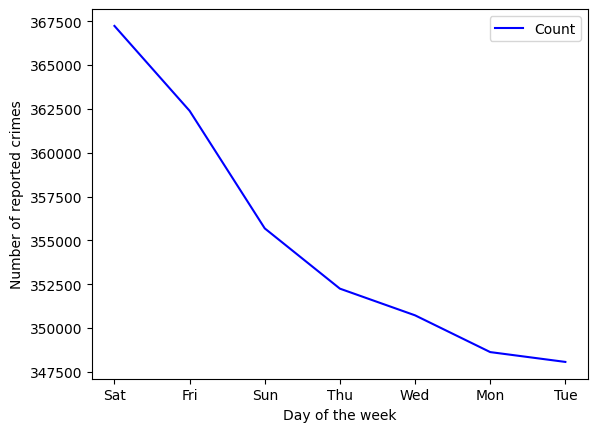

In [74]:
cp.sort_values('Count',ascending=False).plot(kind='line',color='blue',x='Day_of_week',y='Count')
plt.xlabel('Day of the week')
plt.ylabel('Number of reported crimes')

#### **RDDs Setup**

In [73]:
psrdd = sc.textFile('police_station.csv')
psrdd.first()

'DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION'

In [75]:
ps_header = psrdd.first()

In [76]:
ps_rest=psrdd.filter(lambda line: line!=ps_header)
ps_rest.first()

'Headquarters,Headquarters,3510 S Michigan Ave,Chicago,IL,60653,http://home.chicagopolice.org,,,,1177731.401,1881697.404,41.83070169,-87.62339535,"(41.8307016873, -87.6233953459)"'

In [77]:
# How many pilice station are there
#ps_rest.map(lambda line: line.split(',')).collect()
ps_rest.map(lambda line: line.split(',')).count()

24

In [78]:
# Display the District ID, Disctrict name, Address and Zip for the police station
ps_rest.filter(lambda line: line.split(',')[0] == '7').map(lambda line: (line.split(',')[0],
                  line.split(',')[1],
                  line.split(',')[2],
                  line.split(',')[5]
                  )).collect()

[('7', 'Englewood', '1438 W 63rd St', '60636')]

In [79]:
# Police stations 10 and 11 are geographically close to each other. Display the District ID, District name, address and zip code
ps_rest.filter(lambda line: line.split(',')[0] in ['10','11']).map(
    lambda line: (line.split(',')[1],
                  line.split(',')[2],
                  line.split(',')[5])
).collect()

[('Ogden', '3315 W Ogden Ave', '60623'),
 ('Harrison', '3151 W Harrison St', '60612')]